# Prédiction des émissions

## Importations

In [1]:
import numpy as np
import glob
import ntpath
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split
from keras import applications
import cv2

## Préparation des données

In [2]:
os.getcwd()
os.chdir('/home/jovyan/activities_data/hi__paris_2022_hackathon/final_challenge/datasets/Welcoming_final_challenge')

In [3]:
cars_path = "../car_models_footprint.csv"
car_models = pd.read_csv(cars_path, sep=";")

In [4]:
s_pathToImages = pd.Series(glob.glob(r"/home/jovyan/activities_data/hi__paris_2022_hackathon/final_challenge/datasets/datasets_train/car_models_database_train/*"))
s_models = s_pathToImages.apply(lambda x : x.split("/")[-1].split("_")[0])
frame = {"im_name" : s_pathToImages, "models" : s_models}
df_images = pd.DataFrame(frame)

In [5]:
df = pd.merge(car_models, df_images, on = "models")
df.head()

,models,Brand,year,Average Urban Consumption,Average extra-urban consumption,Average mixed consumption,Average of CO2 (g per km),Average CO type I,im_name
0,Chevrolet Corvette ZR1 2012,Chevrolet,2012,19.0,8.9,12.6,293.0,"0,508",/home/jovyan/activities_data/hi__paris_2022_ha...
1,Chevrolet Corvette ZR1 2012,Chevrolet,2012,19.0,8.9,12.6,293.0,"0,508",/home/jovyan/activities_data/hi__paris_2022_ha...
2,Chevrolet Corvette ZR1 2012,Chevrolet,2012,19.0,8.9,12.6,293.0,"0,508",/home/jovyan/activities_data/hi__paris_2022_ha...
3,Chevrolet Corvette ZR1 2012,Chevrolet,2012,19.0,8.9,12.6,293.0,"0,508",/home/jovyan/activities_data/hi__paris_2022_ha...
4,Chevrolet Corvette ZR1 2012,Chevrolet,2012,19.0,8.9,12.6,293.0,"0,508",/home/jovyan/activities_data/hi__paris_2022_ha...


In [6]:
n_classes = 4
discretizer = KBinsDiscretizer(n_bins=n_classes, encode='ordinal', strategy = 'quantile')

df["classe_conso"] = discretizer.fit_transform(np.array(df["Average of CO2 (g per km)"]).reshape(-1, 1)).astype(str)
df["conso_discretized"] = discretizer.inverse_transform(np.array(df["classe_conso"]).reshape(-1, 1))

<AxesSubplot:title={'center':'Comsumption distribution for 4 classes'}, xlabel='Average of CO2 (g per km)', ylabel='Count'>

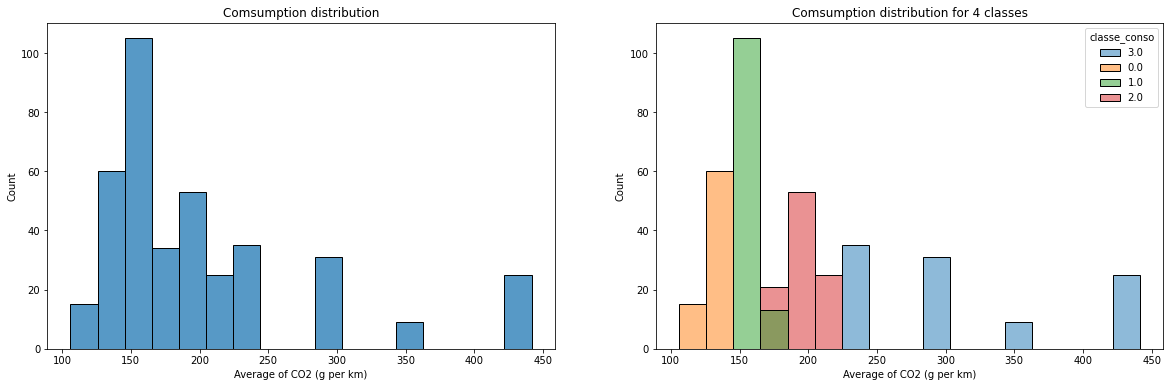

In [7]:
plt.figure(figsize=(20, 6))
ax = plt.subplot(1, 2, 1)
ax.set_title("Comsumption distribution")
sns.histplot(df, x = "Average of CO2 (g per km)")
ax = plt.subplot(1, 2, 2)
ax.set_title("Comsumption distribution for {} classes".format(n_classes))
sns.histplot(df, x = "Average of CO2 (g per km)",hue = "classe_conso")

## Design du modèle

In [168]:
target_size = (256,188,3)

In [169]:
model1 = tf.keras.Sequential()
model1.add(layers.Conv2D(32, (3, 3), padding='same',
                 input_shape=target_size))
model1.add(layers.Activation('relu'))
model1.add(layers.Conv2D(32, (3, 3)))
model1.add(layers.Activation('relu'))
model1.add(layers.MaxPooling2D(pool_size=(2, 2)))
model1.add(layers.Dropout(0.25))

model1.add(layers.Conv2D(64, (3, 3), padding='same'))
model1.add(layers.Activation('relu'))
model1.add(layers.Conv2D(64, (3, 3)))
model1.add(layers.Activation('relu'))
model1.add(layers.MaxPooling2D(pool_size=(2, 2)))
model1.add(layers.Dropout(0.25))

model1.add(layers.Flatten())
model1.add(layers.Dense(512))
model1.add(layers.Activation('relu'))
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(n_classes, activation='softmax'))


def my_metric_fn(y_true, y_pred):
    squared_difference = tf.square(y_true - y_pred)
    return tf.reduce_mean(squared_difference, axis=-1)  # Note the `axis=-1`

model1.compile(keras.optimizers.RMSprop(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"
                                                                                                        # , my_metric_fn
                                                                                                       ])

model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 256, 188, 32)      896       
                                                                 
 activation_15 (Activation)  (None, 256, 188, 32)      0         
                                                                 
 conv2d_29 (Conv2D)          (None, 254, 186, 32)      9248      
                                                                 
 activation_16 (Activation)  (None, 254, 186, 32)      0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 93, 32)      0         
 2D)                                                             
                                                                 
 dropout_13 (Dropout)        (None, 127, 93, 32)       0         
                                                      

In [65]:

model2 = tf.keras.Sequential()
model2.add(layers.Conv2D(32, (3, 3), padding='same',
                 input_shape=target_size))
model2.add(layers.Activation('relu'))
model2.add(layers.Conv2D(32, (3, 3)))
model2.add(layers.Activation('relu'))
model2.add(layers.MaxPooling2D(pool_size=(2, 2)))
model2.add(layers.Dropout(0.25))

model2.add(layers.Conv2D(64, (3, 3), padding='same'))
model2.add(layers.Activation('relu'))
model2.add(layers.Conv2D(64, (3, 3)))
model2.add(layers.Activation('relu'))
model2.add(layers.MaxPooling2D(pool_size=(2, 2)))
model2.add(layers.Dropout(0.25))

model2.add(layers.Flatten())
model2.add(layers.Dense(512))
model2.add(layers.Activation('relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(n_classes, activation='softmax'))


def my_metric_fn(y_true, y_pred):
    squared_difference = tf.square(y_true - y_pred)
    return tf.reduce_mean(squared_difference, axis=-1)  # Note the `axis=-1`

model2.compile(keras.optimizers.Adam(learning_rate=0.00001), loss="categorical_crossentropy", metrics=["accuracy"
                                                                                                        # , my_metric_fn
                                                                                                       ])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 256, 188, 32)      896       
                                                                 
 activation_5 (Activation)   (None, 256, 188, 32)      0         
                                                                 
 conv2d_9 (Conv2D)           (None, 254, 186, 32)      9248      
                                                                 
 activation_6 (Activation)   (None, 254, 186, 32)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 127, 93, 32)      0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 127, 93, 32)       0         
                                                      

In [110]:
base_model3 = tf.keras.applications.Xception(include_top = False, weights = 'imagenet', input_shape = target_size)
# base_model3.summary()

# Freeze
base_model3.trainable = False

# Preprocessing des couches d'entrée
inputs = tf.keras.layers.Input(target_size)
x = tf.keras.applications.xception.preprocess_input(inputs)

# Ajouter des couches finales
x = base_model3(x, training = False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(1000)(x)
outputs = keras.layers.Dense(n_classes)(x)
model3 = keras.Model(inputs, outputs)
model3.summary()

model3.compile(keras.optimizers.Adam(), loss = tf.keras.losses.BinaryCrossentropy(), metrics=["accuracy"
                                                                                                        # , my_metric_fn
                                                                                                       ])

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 256, 188, 3)]     0         
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 256, 188, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_3 (TFOpLam  (None, 256, 188, 3)      0         
 bda)                                                            
                                                                 
 xception (Functional)       (None, 8, 6, 2048)        20861480  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

In [135]:
### FINE TUNING CODE ###

base_model3.trainable = True
model3.compile(keras.optimizers.Adam(learning_rate=0.00001), loss = tf.keras.losses.BinaryCrossentropy(), metrics=["accuracy"
                                                                                                        # , my_metric_fn
                                                                                                       ])

In [111]:
# Callbacks
checkpoint_filepath ='../../group_00099_shared_workspace/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                              save_weights_only=True,
                                                              monitor='val_loss'
                                                              ,mode='min'
                                                              ,save_best_only=True
                                                              , verbose = 1)
reduceLrOnPlateau_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.33, patience = 2
                                                                 , verbose = 1
                                                                 , mode="min")

In [133]:
# Image generator
datagen = ImageDataGenerator(rescale = 1./255.)
datagen = ImageDataGenerator(rescale = 1./255.
                             , vertical_flip=True
                             , brightness_range= [0.5, 1]
                            )

In [135]:
# Choix du modèle à tester
model = model1
# model = model2
# model = model3

## Entraînement du modèle sur le petit dataset

In [136]:
df_train, df_test = train_test_split(df, test_size = 0.2)

train_generator = datagen.flow_from_dataframe(df_train, x_col = "im_name", y_col = "classe_conso", batch_size = 4, target_size = target_size[:2])
validation_generator = datagen.flow_from_dataframe(df_test, x_col = "im_name", y_col = "classe_conso", batch_size = 4, target_size = target_size[:2])

Found 313 validated image filenames belonging to 4 classes.
Found 79 validated image filenames belonging to 4 classes.


In [137]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size
history = model.fit(x=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=20
                   , callbacks=[model_checkpoint_callback
                                # , reduceLrOnPlateau_callback
                               ])
model.load_weights(checkpoint_filepath)

Epoch 1/20
78/78 [==============================] - ETA: 0s - loss: 1.5986 - accuracy: 0.2589
Epoch 00001: val_loss improved from 3.85624 to 1.37985, saving model to ../../group_00099_shared_workspace/tmp/checkpoint
78/78 [==============================] - 11s 128ms/step - loss: 1.5986 - accuracy: 0.2589 - val_loss: 1.3799 - val_accuracy: 0.3026
Epoch 2/20
78/78 [==============================] - ETA: 0s - loss: 1.3811 - accuracy: 0.2783
Epoch 00002: val_loss did not improve from 1.37985
78/78 [==============================] - 8s 108ms/step - loss: 1.3811 - accuracy: 0.2783 - val_loss: 1.3857 - val_accuracy: 0.2105
Epoch 3/20
78/78 [==============================] - ETA: 0s - loss: 1.3630 - accuracy: 0.3560
Epoch 00003: val_loss did not improve from 1.37985
78/78 [==============================] - 9s 109ms/step - loss: 1.3630 - accuracy: 0.3560 - val_loss: 1.3834 - val_accuracy: 0.2763
Epoch 4/20
78/78 [==============================] - ETA: 0s - loss: 1.3534 - accuracy: 0.3430
Epoch 

In [138]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


Text(0.5, 1.0, 'Loss during training')

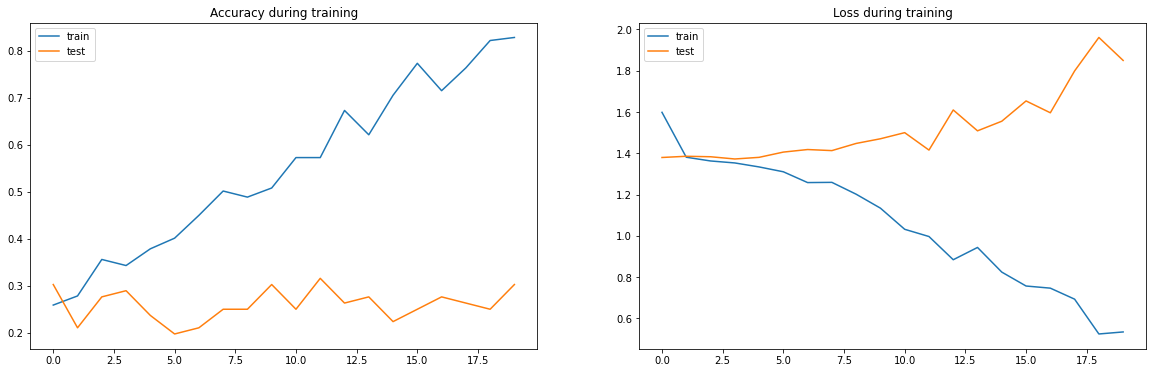

In [139]:
plt.figure(figsize=(20, 6))
ax = plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label = "train")
plt.plot(history.history["val_accuracy"], label = "test")
plt.legend()
plt.title("Accuracy during training")
ax = plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label = "train")
plt.plot(history.history["val_loss"], label = "test")
plt.legend()
plt.title("Loss during training")

### Evaluation des performances

In [192]:
model.evaluate(validation_generator)

20/20 [==============================] - 2s 81ms/step - loss: 1.3707 - accuracy: 0.2785


[1.3707250356674194, 0.27848100662231445]

In [193]:
pred = model.predict(validation_generator)
print(pred[:3])

[[0.1908458  0.33922747 0.2606148  0.20931195]
 [0.20355506 0.27660447 0.23682958 0.2830109 ]
 [0.14674562 0.4791221  0.18673982 0.18739244]]


In [194]:
#Classes prédites
print(np.argmax(pred, axis =1)[:])
print("Classes prédites", np.unique(np.argmax(pred, axis =1), return_counts = True))

[1 3 1 1 3 1 1 1 1 3 1 3 1 1 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1
 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 3 1 1 1 2 1 2 2 1 1 1 1 1 1
 1 1 1 1 2]
Classes prédites (array([1, 2, 3]), array([65,  8,  6]))


In [195]:
classe_emissions = discretizer.inverse_transform(np.arange(discretizer.n_bins).reshape(-1,1))
classe_emissions

array([[129.76678445],
       [161.6751614 ],
       [199.10837695],
       [335.06065575]])

In [196]:
pred_naiveMean = df_train["Average of CO2 (g per km)"].mean()
pred_emission = np.array([classe_emissions[i] for i in np.argmax(pred, axis =1)]).ravel()
pred_emission_ponderees = (pred@classe_emissions).ravel() ##* 150/pred_emission.mean()
pred_emission_PondereesRescalees = (pred@classe_emissions).ravel() * df_train["Average of CO2 (g per km)"].mean()/pred_emission_ponderees.mean()
pred_emission_rescalees = pred_emission * df_train["Average of CO2 (g per km)"].mean()/pred_emission_ponderees.mean()
d_pred = {"pred_emission":pred_emission, "pred_emission_ponderees" :pred_emission_ponderees , "pred_emission_PondereesRescalees" :pred_emission_PondereesRescalees , "pred_emission_rescalees" : pred_emission_rescalees, "pred_naiveMean": pred_naiveMean}

In [197]:
pred_emission[:3], pred_emission_ponderees[:3], pred_emission_PondereesRescalees[:3], pred_emission_rescalees[:3]

(array([161.6751614 , 335.06065575, 161.6751614 ]),
 array([201.63289231, 213.11532963, 196.47414763]),
 array([198.89023995, 210.21649078, 193.80166559]),
 array([159.47602237, 330.50309132, 159.47602237]))

In [198]:
y_true = df_test["Average of CO2 (g per km)"].values

def MAPE(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred)/y_true)
print("Résultats sur le petit dataset\n")
print("Discrétisation en ", n_classes, " classes")
for k, v in d_pred.items():
    print(k, "a pour MAPE sur df_test : ", round(MAPE(y_true, v), 2))

Résultats sur le petit dataset

Discrétisation en  4  classes
pred_emission a pour MAPE sur df_test :  0.27
pred_emission_ponderees a pour MAPE sur df_test :  0.3
pred_emission_PondereesRescalees a pour MAPE sur df_test :  0.29
pred_emission_rescalees a pour MAPE sur df_test :  0.26
pred_naiveMean a pour MAPE sur df_test :  0.29


In [199]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 256, 188, 32)      896       
                                                                 
 activation_10 (Activation)  (None, 256, 188, 32)      0         
                                                                 
 conv2d_25 (Conv2D)          (None, 254, 186, 32)      9248      
                                                                 
 activation_11 (Activation)  (None, 254, 186, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 127, 93, 32)      0         
 2D)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 127, 93, 32)       0         
                                                      

In [201]:
saving_path = '/home/jovyan/activities_data/hi__paris_2022_hackathon/final_challenge/group_00099_shared_workspace/models/model_pred_emission.h5'

model.save(saving_path)

In [200]:
os.getcwd()

'/home/jovyan/activities_data/hi__paris_2022_hackathon/final_challenge/datasets/Welcoming_final_challenge'

array([[6.4465508e-04, 9.9725717e-01, 1.0492865e-03, 1.0488592e-03]],
      dtype=float32)

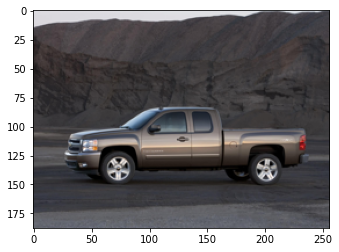

In [304]:
image = Image.open(im_path)
new_image = image.resize(target_size[:2])
im = np.asanyarray(new_image)
plt.imshow(im)
im = np.expand_dims(im, axis=0)
im.shape
model.predict(im)

In [2]:
from keras.models import load_model
import cv2
model_emissions = load_model('/home/jovyan/activities_data/hi__paris_2022_hackathon/final_challenge/group_00099_shared_workspace/models/model_pred_emission.h5')

(1536, 2048, 3)
(256, 188, 3)


array([[2.7257985e-07, 9.9996591e-01, 4.5924190e-07, 3.3442822e-05]],
      dtype=float32)

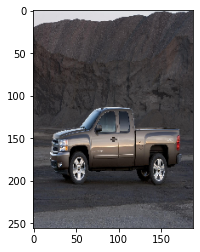

In [10]:
target_size = (188,256,3)

im_path = glob.glob("../datasets/datasets_test/test/*")[0]
image = Image.open(im_path)
im = np.asanyarray(image)
print(im.shape)
im = cv2.resize(im, dsize=target_size[:2], interpolation=cv2.INTER_CUBIC)
print(im.shape)
plt.imshow(im)
im = np.expand_dims(im, axis=0)
im.shape
model_emissions.predict(im)

In [10]:
df["Average of CO2 (g per km)"].mean()

201.73246813265277

In [9]:
target_size[:2]

(256, 188)

## Entraînement du modèle sur le gros dataset purgé des images non voitures

In [181]:
emission_data = pd.read_csv("../../datasets/car_models_footprint.csv", sep=";")

path_annotrain = "../../datasets/datasets_train/train_annotation/_annotation.csv"

train_annotation = pd.read_csv(path_annotrain, index_col=0)
train_annotation = train_annotation[train_annotation["models"]!=" "]

df_carsInTheWild = pd.merge(train_annotation, emission_data, "inner", on="models")
df_carsInTheWild["path"] = r'/home/jovyan/activities_data/hi__paris_2022_hackathon/final_challenge/datasets/datasets_train/train/' + df_carsInTheWild["im_name"]

n_classes = 2
discretizer = KBinsDiscretizer(n_bins=n_classes, encode='ordinal', strategy = 'kmeans')

df_carsInTheWild["classe_conso"] = discretizer.fit_transform(np.array(df_carsInTheWild["Average of CO2 (g per km)"]).reshape(-1, 1)).astype(str)
df_carsInTheWild["conso_discretized"] = discretizer.inverse_transform(np.array(df_carsInTheWild["classe_conso"]).reshape(-1, 1))

In [182]:
print("Nb lignes : ", len(df_carsInTheWild))
df_carsInTheWild.head()

Nb lignes :  1309


,im_name,x_min,y_min,x_max,y_max,class,models,Brand,year,Average Urban Consumption,Average extra-urban consumption,Average mixed consumption,Average of CO2 (g per km),Average CO type I,path,classe_conso,conso_discretized
0,107347968.jpg,40.0,244.0,1144.0,637.0,car,Audi S5 Convertible 2012,Audi,2012,7.90636,5.3053,6.262544,153.533569,"0,298187279",/home/jovyan/activities_data/hi__paris_2022_ha...,0.0,170.352101
1,109641728.jpg,278.0,284.0,917.0,539.0,car,Audi S5 Convertible 2012,Audi,2012,7.90636,5.3053,6.262544,153.533569,"0,298187279",/home/jovyan/activities_data/hi__paris_2022_ha...,0.0,170.352101
2,111214592.jpg,29.0,133.0,350.0,263.0,car,Audi S5 Convertible 2012,Audi,2012,7.90636,5.3053,6.262544,153.533569,"0,298187279",/home/jovyan/activities_data/hi__paris_2022_ha...,0.0,170.352101
3,110821376.jpg,34.0,71.0,245.0,160.0,car,Audi S5 Convertible 2012,Audi,2012,7.90636,5.3053,6.262544,153.533569,"0,298187279",/home/jovyan/activities_data/hi__paris_2022_ha...,0.0,170.352101
4,109379584.jpg,99.0,147.0,712.0,516.0,car,Audi S5 Convertible 2012,Audi,2012,7.90636,5.3053,6.262544,153.533569,"0,298187279",/home/jovyan/activities_data/hi__paris_2022_ha...,0.0,170.352101


<AxesSubplot:title={'center':'Distribution des consommations pour 2 classes'}, xlabel='Average of CO2 (g per km)', ylabel='Count'>

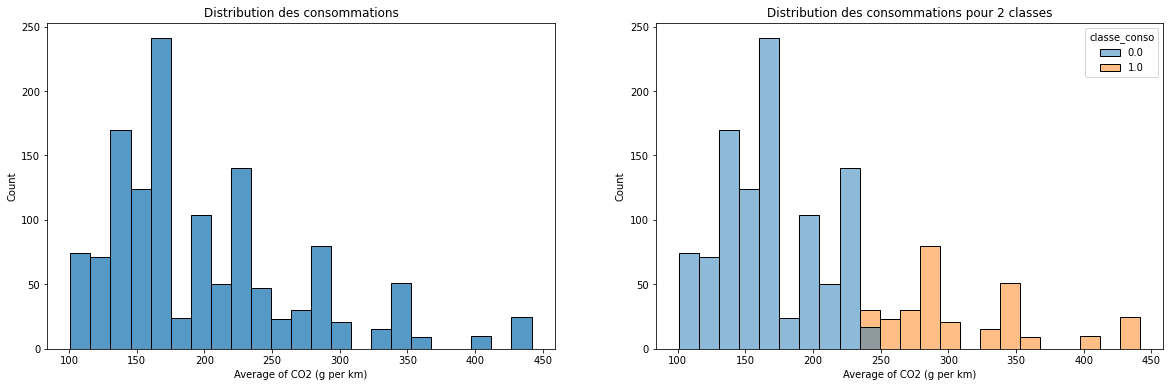

In [183]:
plt.figure(figsize=(20, 6))
ax = plt.subplot(1, 2, 1)
ax.set_title("Distribution des consommations")
sns.histplot(df_carsInTheWild, x = "Average of CO2 (g per km)")
ax = plt.subplot(1, 2, 2)
ax.set_title("Distribution des consommations pour {} classes".format(n_classes))
sns.histplot(df_carsInTheWild, x = "Average of CO2 (g per km)",hue = "classe_conso")

In [301]:
df_train, df_test = train_test_split(df_carsInTheWild, test_size = 0.2)

train_generator = datagen.flow_from_dataframe(df_train, x_col = "path", y_col = "classe_conso", batch_size = 4, target_size = target_size[:2])
validation_generator = datagen.flow_from_dataframe(df_test, x_col = "path", y_col = "classe_conso", batch_size = 4, target_size = target_size[:2])

Found 1047 validated image filenames belonging to 2 classes.
Found 262 validated image filenames belonging to 2 classes.


In [303]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size
history = model.fit(x=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=20
                   , callbacks=[model_checkpoint_callback, reduceLrOnPlateau_callback])
model.load_weights(checkpoint_filepath)

Epoch 1/20
260/261 [============================>.] - ETA: 0s - loss: 0.5494 - accuracy: 0.7777
Epoch 00001: val_loss improved from 0.62229 to 0.59131, saving model to ../../group_00099_shared_workspace/tmp/checkpoint
261/261 [==============================] - 13s 51ms/step - loss: 0.5485 - accuracy: 0.7785 - val_loss: 0.5913 - val_accuracy: 0.7577 - lr: 1.0000e-04
Epoch 2/20
260/261 [============================>.] - ETA: 0s - loss: 0.5441 - accuracy: 0.7777
Epoch 00002: val_loss improved from 0.59131 to 0.58935, saving model to ../../group_00099_shared_workspace/tmp/checkpoint
261/261 [==============================] - 12s 47ms/step - loss: 0.5434 - accuracy: 0.7785 - val_loss: 0.5894 - val_accuracy: 0.7577 - lr: 1.0000e-04
Epoch 3/20
261/261 [==============================] - ETA: 0s - loss: 0.5354 - accuracy: 0.7795
Epoch 00003: val_loss did not improve from 0.58935
261/261 [==============================] - 12s 46ms/step - loss: 0.5354 - accuracy: 0.7795 - val_loss: 0.5982 - val_a

In [304]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


Text(0.5, 1.0, 'Loss during training')

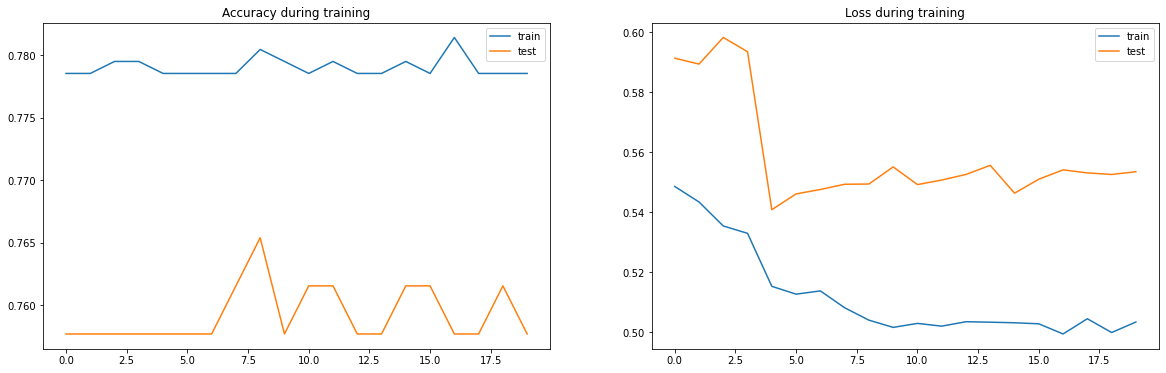

In [305]:
plt.figure(figsize=(20, 6))
ax = plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label = "train")
plt.plot(history.history["val_accuracy"], label = "test")
plt.legend()
plt.title("Accuracy during training")
ax = plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label = "train")
plt.plot(history.history["val_loss"], label = "test")
plt.legend()
plt.title("Loss during training")

### Evaluation des performances

In [306]:
model.evaluate(validation_generator)

66/66 [==============================] - 2s 32ms/step - loss: 0.5403 - accuracy: 0.7595


[0.5403136014938354, 0.7595419883728027]

In [307]:
pred = model.predict(validation_generator)
print(pred[:3])

[[0.68386376 0.3161362 ]
 [0.6886688  0.3113312 ]
 [0.6484113  0.3515888 ]]


In [308]:
#Classes prédites
print(np.argmax(pred, axis =1)[:])
print("Classes prédites", np.unique(np.argmax(pred, axis =1), return_counts = True))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Classes prédites (array([0]), array([262]))


In [309]:
classe_emissions = discretizer.inverse_transform(np.arange(discretizer.n_bins).reshape(-1,1))
classe_emissions

array([[170.35210076],
       [340.71275651]])

In [310]:
pred_naiveMean = df_train["Average of CO2 (g per km)"].mean()
pred_emission = np.array([classe_emissions[i] for i in np.argmax(pred, axis =1)]).ravel()
pred_emission_ponderees = (pred@classe_emissions).ravel() ##* 150/pred_emission.mean()
pred_emission_PondereesRescalees = (pred@classe_emissions).ravel() * df_train["Average of CO2 (g per km)"].mean()/pred_emission_ponderees.mean()
pred_emission_rescalees = pred_emission * df_train["Average of CO2 (g per km)"].mean()/pred_emission_ponderees.mean()
d_pred = {"pred_emission":pred_emission, "pred_emission_ponderees" :pred_emission_ponderees , "pred_emission_PondereesRescalees" :pred_emission_PondereesRescalees , "pred_emission_rescalees" : pred_emission_rescalees, "pred_naiveMean": pred_naiveMean}

In [311]:
pred_emission[:3], pred_emission_ponderees[:3], pred_emission_PondereesRescalees[:3], pred_emission_rescalees[:3]

(array([170.35210076, 170.35210076, 170.35210076]),
 array([224.20926793, 223.39069028, 230.24900699]),
 array([200.97592953, 200.24217573, 206.38980998]),
 array([152.69962796, 152.69962796, 152.69962796]))

In [312]:
y_true = df_test["Average of CO2 (g per km)"].values

def MAPE(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred)/y_true)
print("Résultats sur le gros dataset\n")
print("Discrétisation en ", n_classes, " classes")
for k, v in d_pred.items():
    print(k, "a pour MAPE sur df_test : ", round(MAPE(y_true, v), 2))

Résultats sur le gros dataset

Discrétisation en  2  classes
pred_emission a pour MAPE sur df_test :  0.25
pred_emission_ponderees a pour MAPE sur df_test :  0.37
pred_emission_PondereesRescalees a pour MAPE sur df_test :  0.31
pred_emission_rescalees a pour MAPE sur df_test :  0.26
pred_naiveMean a pour MAPE sur df_test :  0.3


# Bac à sable <>

## 1 - Fixation de la taille d'entrée des images pour le réseau de neurones

In [184]:
path_ds_carsInTheWild = '/home/jovyan/activities_data/hi__paris_2022_hackathon/final_challenge/datasets/datasets_train/train/*.jpg'
l_sizes = []
for path_im in df_carsInTheWild["path"]:
    im = Image.open(path_im)
    l_sizes.append(im.size)

In [185]:
quantiles =np.arange(0,1, 0.01)
quantiles_values = np.quantile(np.array(l_sizes), quantiles,  axis = 0)

array([259., 188.])

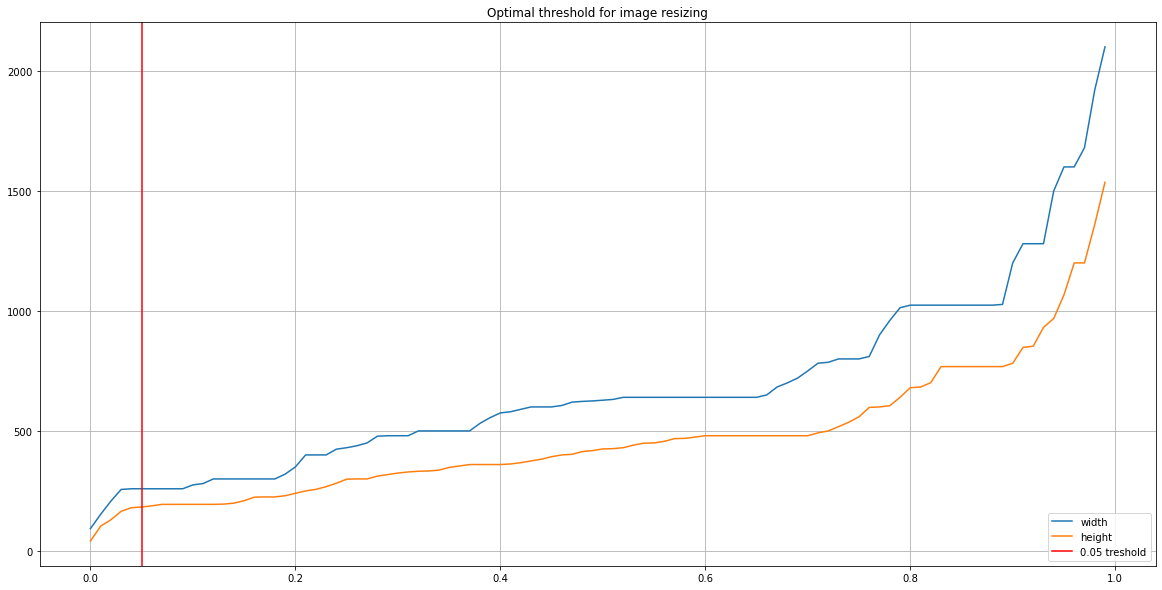

In [186]:
thresh = 0.05

plt.figure(figsize=(20, 10))
plt.grid()
plt.plot(quantiles, quantiles_values[:, 0], label = "width")
plt.plot(quantiles, quantiles_values[:, 1], label = "height")
plt.axvline(x=thresh, c = 'red', label = str(thresh) + ' treshold')
plt.legend()
plt.title("Optimal threshold for image resizing")


quantiles_values[np.where(quantiles>thresh)[0][0]]

In [187]:
im = Image.open('/home/jovyan/activities_data/hi__paris_2022_hackathon/final_challenge/datasets/datasets_train/train/1010368512.jpg')
im.size

(720, 450)

## 2 - Stanford Cars Dataset

In [9]:
import torch
import torchvision.models as models

In [1]:
!pip install pytorch2keras;
# !pip install onnx;
!pip install git+git://github.com/onnx/onnx.git@master

  Cloning git://github.com/onnx/onnx.git (to revision master) to /tmp/pip-req-build-_o8i4tdo
  Running command git clone --filter=blob:none --quiet git://github.com/onnx/onnx.git /tmp/pip-req-build-_o8i4tdo
  Running command git checkout -q master
  error: pathspec 'master' did not match any file(s) known to git
  error: subprocess-exited-with-error
  
  × git checkout -q master did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

× git checkout -q master did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [6]:
from pytorch2keras.converter import pytorch_to_keras
# from onnx import optimizer

ImportError: cannot import name 'optimizer' from 'onnx' (/opt/conda/lib/python3.8/site-packages/onnx/__init__.py)

In [149]:
os.getcwd()

'/home/jovyan/activities_data/hi__paris_2022_hackathon/final_challenge/datasets/Welcoming_final_challenge'

In [16]:
model4 = torch.load('/home/jovyan/activities_data/hi__paris_2022_hackathon/final_challenge/group_00099_shared_workspace/datasets/stanford_cars_tresnet-l-v2_96_27.pth')

In [18]:
from torchvision import models
import torchsummary
torchsummary.summary(model4, (3, 224, 224))

AttributeError: 'dict' object has no attribute 'apply'

In [13]:
!pip install torchsummary